In [117]:
from transformers import AutoTokenizer,LlamaConfig,GenerationConfig
import torch
import os
import pandas as pd
import numpy as np
import pickle
import glob
import re
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm
from matplotlib.gridspec import GridSpec
import seaborn as sns
import string
import statsmodels.api as sm
from statsmodels.formula.api import ols
import itertools
import sys
sys.path.append('/home/jianing/generation/Memory_generation')
from utils import get_segmentation_indices,segmentation_to_word_list
from utils import calculate_cross_entropy,normalize_entropy,model_to_path_dict
sns.set_context('paper')

In [110]:
save_dir = '/home/jianing/generation/generated'
model_name = 'Llama3-8b-instruct'
model_save_dir_name = model_to_path_dict[model_name]['save_dir_name']
stories = ['pieman','alternateithicatom','odetostepfather','souls','legacy','wheretheressmoke','adventuresinsayingyes','inamoment']
story_to_idx_mapping = {s:stories.index(s)+1 for s in stories}

In [3]:
adjusted = True
if adjusted:
    uniform_encoding_df_name = 'uniform_encoding_df_even_split_adjusted.csv'
    figure_save_dir = os.path.join(save_dir,model_save_dir_name,'uniform_encoding','figures_even_split','adjusted')
else:
    uniform_encoding_df_name = 'uniform_encoding_df_even_split.csv'
    figure_save_dir = os.path.join(save_dir,model_save_dir_name,'uniform_encoding','figures_even_split')
if not os.path.exists(figure_save_dir):
    os.makedirs(figure_save_dir)

In [4]:
uniform_encoding_dfs = []
for story in stories:
    uniform_encoding_save_dir = os.path.join(save_dir,model_save_dir_name,'uniform_encoding',story)
    # these csv are saved in uniform encoding hypothesis.ipynb
    story_uniform_encoding_df = pd.read_csv(os.path.join(uniform_encoding_save_dir,uniform_encoding_df_name))
    story_uniform_encoding_df['story']=story
    uniform_encoding_dfs.append(story_uniform_encoding_df)
all_uniform_encoding_df = pd.concat(uniform_encoding_dfs,ignore_index= True)

In [5]:
# rename otherwise statsmodels complains
all_uniform_encoding_df = all_uniform_encoding_df.rename(columns={'H(event)': 'H_event'})
all_uniform_encoding_df =all_uniform_encoding_df.rename(columns={'H(event|prev events)': 'H_event_conditioned'})

In [259]:
np.mean(all_uniform_encoding_df['event_duration']),np.std(all_uniform_encoding_df['event_duration']),

(33.79042721309758, 3.717583582697814)

In [6]:
all_uniform_encoding_df.keys()

Index(['H_event_conditioned', 'H_event', 'event_len', 'event_duration',
       'weighted_event_info', 'weighted_event_info_by_duration',
       'weighted_event_info_conditioned', 'mean_ER_intersect',
       'mean_ER_intersect_recall_last', 'mean_ER_intersect_instruct',
       'mean_ER_intersect_instruct_recall_last', 'story'],
      dtype='object')

In [112]:
all_uniform_encoding_df['z_weighted_event_info'] = all_uniform_encoding_df.groupby('story')['weighted_event_info'].transform(stats.zscore)
all_uniform_encoding_df['z_weighted_event_info_by_duration'] = all_uniform_encoding_df.groupby('story')['weighted_event_info_by_duration'].transform(stats.zscore)
all_uniform_encoding_df['z_weighted_event_info_conditioned'] = all_uniform_encoding_df.groupby('story')['weighted_event_info_conditioned'].transform(stats.zscore)
all_uniform_encoding_df['story_idx'] = ['Story '+str(story_to_idx_mapping[s]) for s in all_uniform_encoding_df['story'].values]

In [251]:
plotting_label_dict = {
    "weighted_event_info": "CRUISE (Number of tokens)",
    "weighted_event_info_by_duration": "CRUISE (Duration)", 
    "weighted_event_info_conditioned": "Surprisal-weighted sampling",
    'H_event_conditioned': "Surprisal",
    'H_event': "Total information",
    'event_duration': "Duration",
    "event_len": "Number of tokens",
}
plotting_label_dict_sm = {
    "weighted_event_info_by_duration": "CRUISE", 
    "weighted_event_info_conditioned": "Surprisal-weighted sampling",
    'H_event_conditioned': "Surprisal",
    'H_event': "Total information",
    'event_duration': "Duration",
    "event_len": "Number of tokens",
}

## predict I(Xi;R)

#### scatter plot with common intercept and story interaction

In [190]:
def bootstrap_ci(pred,n_bootstraps=1000,spacing =100):
    '''pred: string of predictor'''
    boot_preds = {story: np.zeros((n_bootstraps, spacing)) for story in stories}

    for b in tqdm(range(n_bootstraps)):
        boot_sample = all_uniform_encoding_df.sample(frac=1, replace=True)  # Resample entire dataset
        boot_model = ols('mean_ER_intersect ~ %s+%s:C(story)'%(pred,pred), data=boot_sample).fit()

        for story in stories:
            subset = all_uniform_encoding_df[all_uniform_encoding_df['story'] == story]
            # range of x for that story
            x_range = np.linspace(subset[pred].min(), subset[pred].max(), spacing)
            pred_df = pd.DataFrame({xx:x_range,'story':story})
            boot_preds[story][b, :] = boot_model.predict(pred_df)
    return boot_preds

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

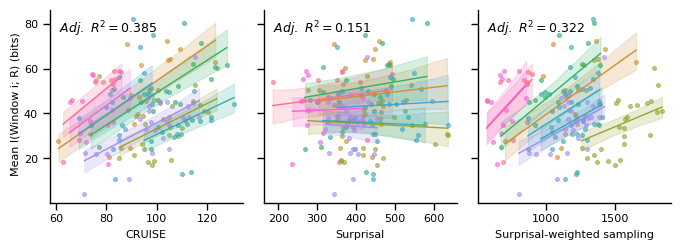

In [261]:
plot_fontsize = 8
# sometimes this will plot without the y axis ticks. The trick is to comment out the code that gets rid of the y axis, plot once, then plot with the full code 
fig, axs = plt.subplots(1, 3, figsize=(7,2.5),sharey = True)

plotting_preds = ['weighted_event_info_by_duration','H_event_conditioned','weighted_event_info_conditioned']
plotting_title = [plotting_label_dict_sm[p] for p in plotting_preds]
#plotting_xlabel = ['Constant-rate incremental uniform sampling \n(duration)','Constant-rate incremental uniform sampling \n(# tokens)','Incremental uniform sampling']
for ax,xx,title in zip(axs,plotting_preds,plotting_title):
    # allow different stories to have different slopes
    fit = ols('mean_ER_intersect ~ %s+%s:C(story)'%(xx,xx), data=all_uniform_encoding_df).fit() 
    adj_r2 = fit.rsquared_adj
    boot_preds = bootstrap_ci(xx)
    
    for i, story in enumerate(stories):
        subset = all_uniform_encoding_df[all_uniform_encoding_df['story'] == story]
        ax.scatter(subset[xx], subset['mean_ER_intersect'], 
                    color=sns.color_palette("husl", len(stories))[i], 
                    label='Story '+str(story_to_idx_mapping[story]), alpha=0.6,s=8)

        # 95% bootstrapped CI
        ci_lower, ci_upper = np.percentile(boot_preds[story], [2.5, 97.5], axis=0)

        x_range = np.linspace(subset[xx].min(), subset[xx].max(), 100)
        pred_df = pd.DataFrame({xx:x_range,'story':story})
        y_fit = fit.predict(pred_df)

        # Plot regression line
        ax.plot(x_range, y_fit, color=sns.color_palette("husl", len(stories))[i],lw=1)

        # Plot bootstrapped confidence interval
        ax.fill_between(x_range, ci_lower, ci_upper, color=sns.color_palette("husl", len(stories))[i], alpha=0.2)


        
    ax.set_ylabel('')
    ax.set_xlabel(title,fontsize = 8)
    #ax.set_xlabel(xlabel,fontsize = 13)
    ax.set_title('')
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_aspect(np.diff(ax.get_xlim())/np.diff(ax.get_ylim()))
    ax.text(0.05, 0.95, r'$Adj.\ R^2 = %.3f$'%adj_r2, ha='left', va='top', transform=ax.transAxes,fontsize =9)


#fig.supxlabel('Prediction by variants of the uniform incremental sampling model and control',fontsize = 8,y = 0.035)
fig.supylabel('Mean I(Window i; R) (bits)',fontsize = 8,y=0.55,x = 0.0355)
#plt.title('Predict I(Xi;R) under uniform encoding in time hypothesis',fontsize = 14)

sns.despine()
plt.tight_layout()
# get rid of y axis on the right 2 plots 
for ax in axs[1:]:
    ax.tick_params(axis='y', which='both', labelleft=False)  
axs[0].tick_params(axis='y', which='both', labelleft=True)
plt.savefig(os.path.join(figure_save_dir,'uniform_encoding_2models_control_direct_concat_interaction_only.svg'), transparent=True)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

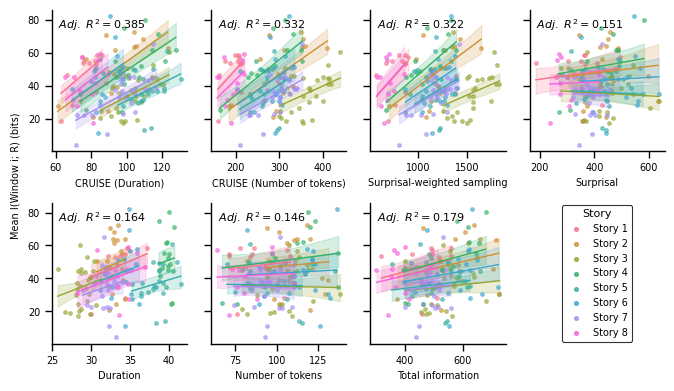

In [263]:
plot_fontsize = 7
# sometimes this will plot without the y axis ticks. The trick is to comment out the code that gets rid of the y axis, plot once, then plot with the full code 
fig,axes = plt.subplots(2,4,figsize = (7,4),sharey=True)

plotting_preds = ['weighted_event_info_by_duration','weighted_event_info','weighted_event_info_conditioned','H_event_conditioned','event_duration','event_len','H_event']
plotting_title = [plotting_label_dict[p] for p in plotting_preds]
#plotting_xlabel = ['Constant-rate incremental uniform sampling \n(duration)','Constant-rate incremental uniform sampling \n(# tokens)','Incremental uniform sampling']
for ax,xx,title in zip(axes.flatten(),plotting_preds,plotting_title):
    # allow different stories to have different slopes
    fit = ols('mean_ER_intersect ~ %s+%s:C(story)'%(xx,xx), data=all_uniform_encoding_df).fit() 
    #fit = ols('mean_ER_intersect ~ %s+C(story)'%(xx), data=all_uniform_encoding_df).fit() 
    adj_r2 = fit.rsquared_adj
    boot_preds = bootstrap_ci(xx)
    
    for i, story in enumerate(stories):
        subset = all_uniform_encoding_df[all_uniform_encoding_df['story'] == story]
        ax.scatter(subset[xx], subset['mean_ER_intersect'], 
                    color=sns.color_palette("husl", len(stories))[i], 
                    label='Story '+str(story_to_idx_mapping[story]), alpha=0.6,s=7)

        # 95% bootstrapped CI
        ci_lower, ci_upper = np.percentile(boot_preds[story], [2.5, 97.5], axis=0)

        x_range = np.linspace(subset[xx].min(), subset[xx].max(), 100)
        pred_df = pd.DataFrame({xx:x_range,'story':story})
        y_fit = fit.predict(pred_df)

        # Plot regression line
        ax.plot(x_range, y_fit, color=sns.color_palette("husl", len(stories))[i],lw=1)

        # Plot bootstrapped confidence interval
        ax.fill_between(x_range, ci_lower, ci_upper, color=sns.color_palette("husl", len(stories))[i], alpha=0.2)
    
    ax.set_ylabel('')
    ax.set_xlabel(title,fontsize = plot_fontsize)
    #ax.set_xlabel(xlabel,fontsize = 13)
    ax.set_title('')
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=7)
    #ax.set_aspect(np.diff(ax.get_xlim())/np.diff(ax.get_ylim()))
    ax.text(0.05, 0.95, r'$Adj.\ R^2 = %.3f$'%adj_r2, ha='left', va='top', transform=ax.transAxes,fontsize =plot_fontsize+1)

#plt.legend(title = 'Story',edgecolor='black',loc = 'lower right')
#fig.supxlabel('Prediction by variants of uniform incremental sampling model and controls',fontsize = plot_fontsize,y = 0.055)
fig.supylabel('Mean I(Window i; R) (bits)',fontsize = plot_fontsize,y=0.55,x = 0.03)
#plt.title('Predict I(Xi;R) under uniform encoding in time hypothesis',fontsize = 14)

sns.despine()
plt.tight_layout()

last_axis = axes.flatten()[-1]
handles, labels = scatter.get_legend_handles_labels()  # Extract legend elements
last_axis.legend(handles, labels, loc='center', title = 'Story',edgecolor='black',fontsize=plot_fontsize,title_fontsize=plot_fontsize+1)
last_axis.axis('off')  # Turn off the axes for a cleaner legend placement

plt.savefig(os.path.join(figure_save_dir,'uniform_encoding_all_models_controls_direct_concat_interaction_only.svg'), transparent=True)